In [1]:
!pip install rdkit

In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.8 MB/s eta 0:00:00a 0:00:01


In [2]:
%run MetaboliteModelFunctions.ipynb

In [3]:
trainFile = 'training_data.csv'
testFile = 'test_data.csv'
train_X, train_Y, test_X, test_Y = makeTrainAndTest(trainFile, testFile, 'pIC50', "RDKit")

In [3]:
tX = test_X
tY = test_Y

test_X = train_X
test_Y = train_Y

train_X = tX
train_Y = tY

In [5]:
importStatements()

In [6]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
myPreds, predictionStats = loopedKfoldCrossVal('XGBR', 10, test_X, test_Y)

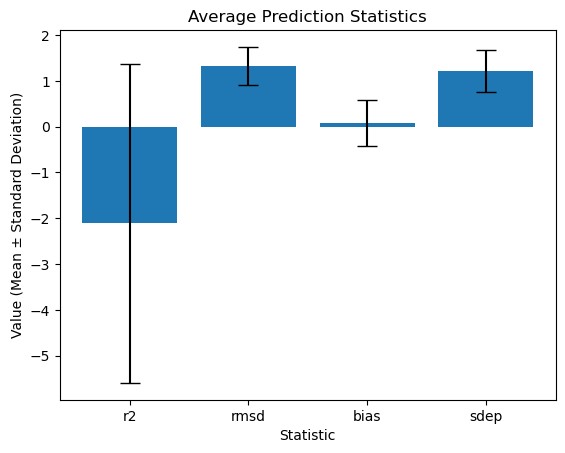

In [5]:
createAvgBarChart(predictionStats)

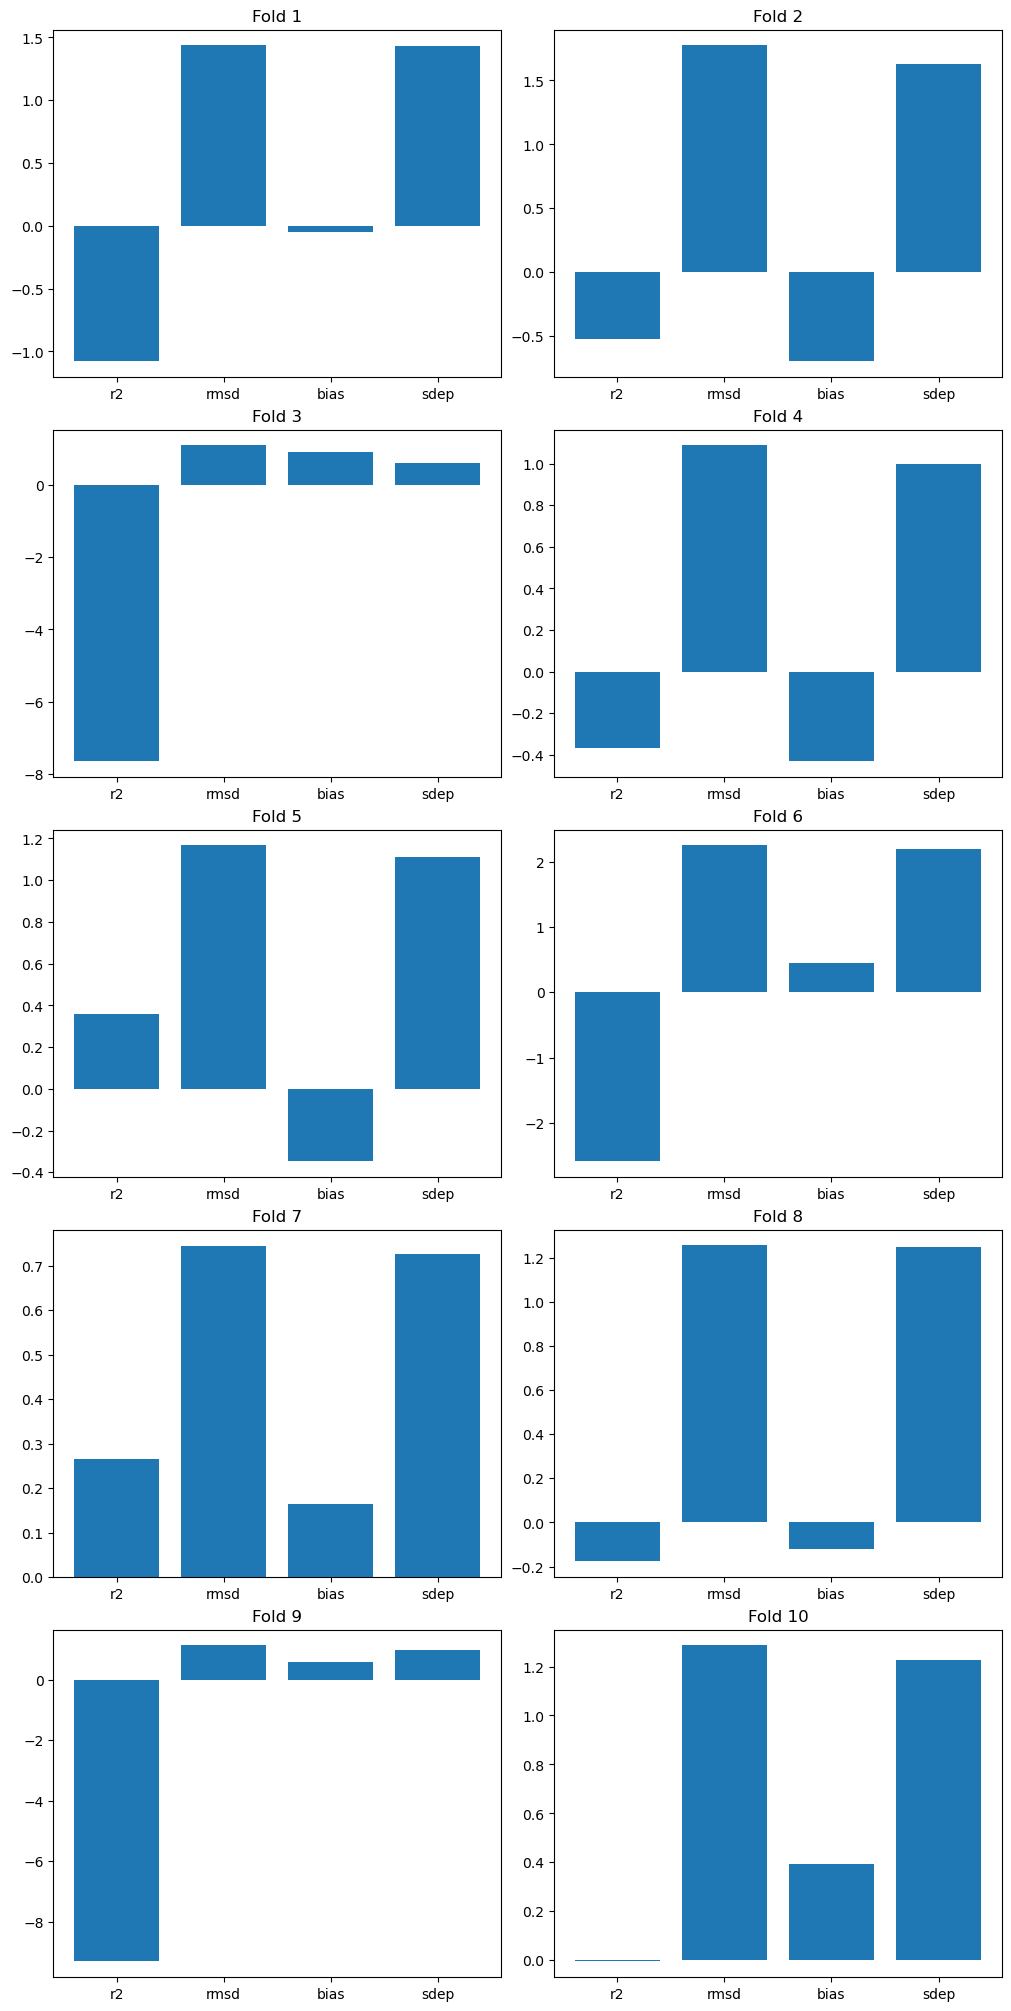

In [6]:
createSplitsBarChart(predictionStats)

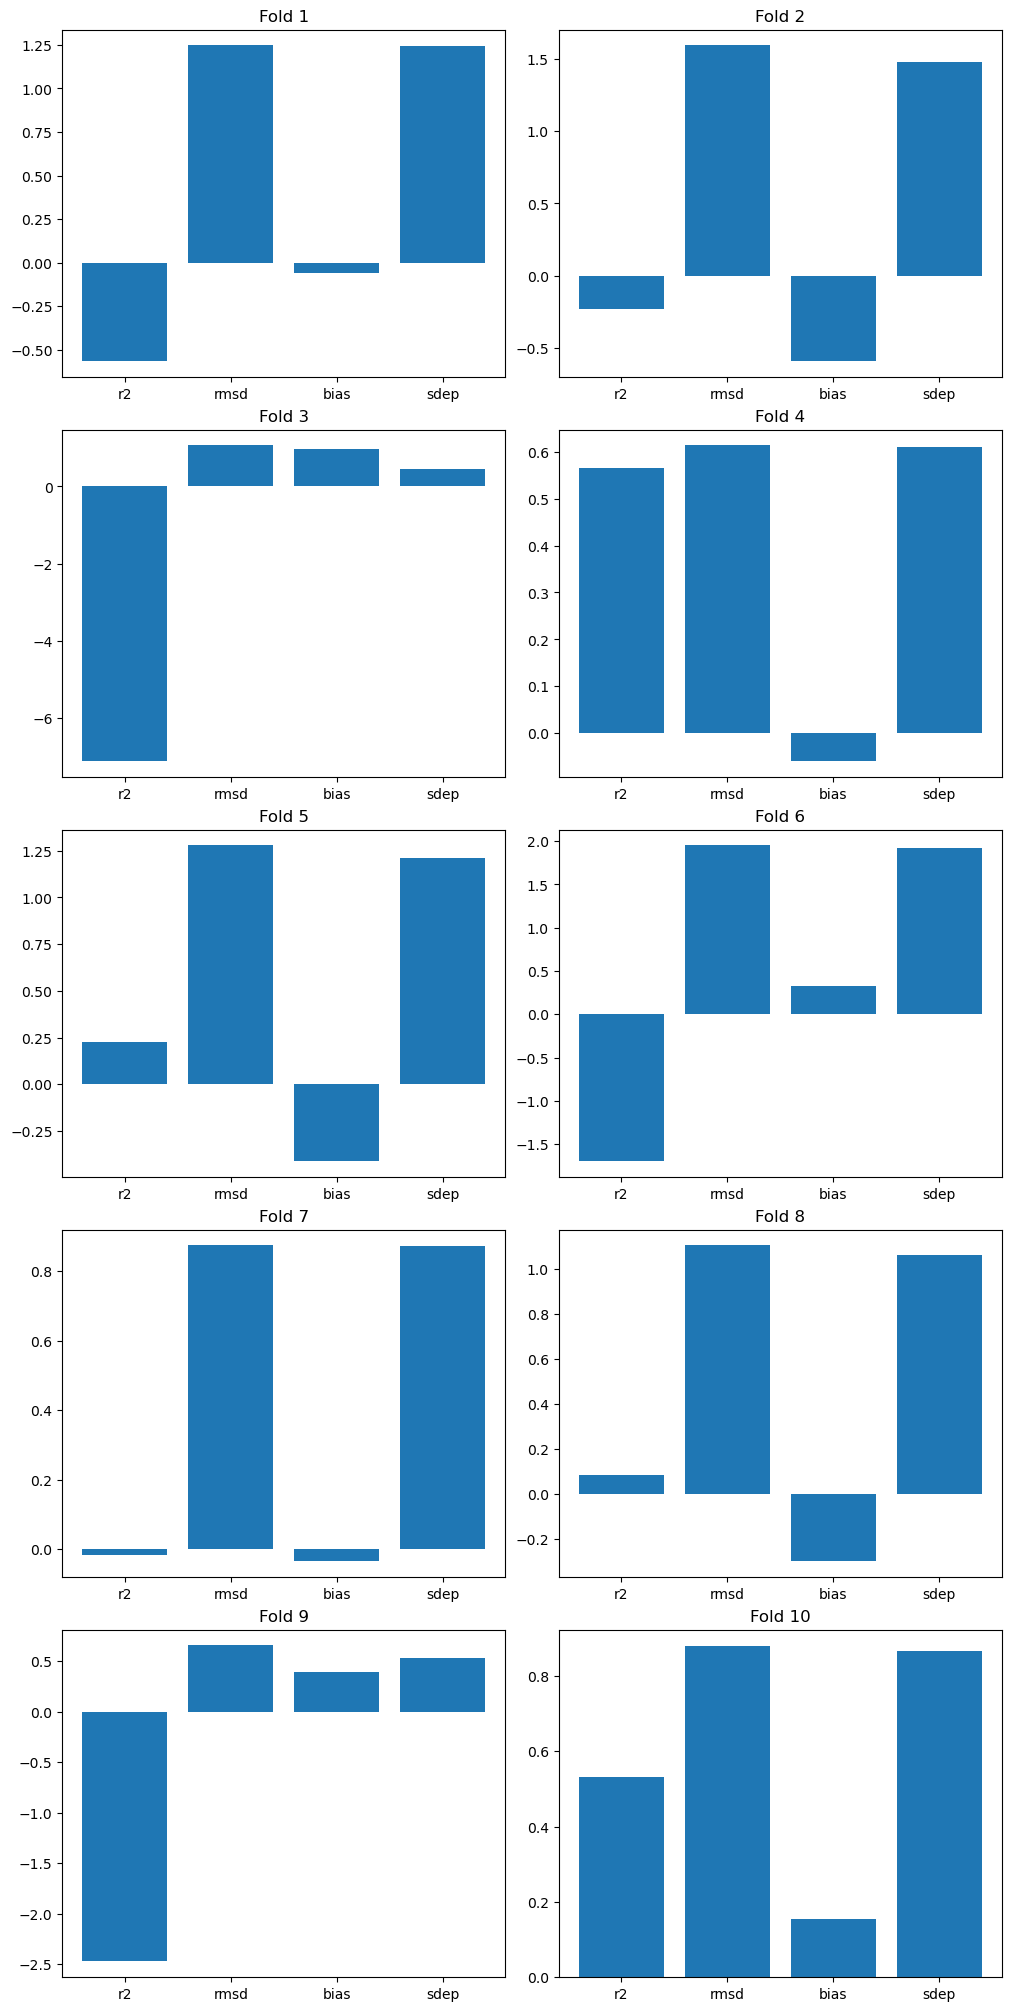

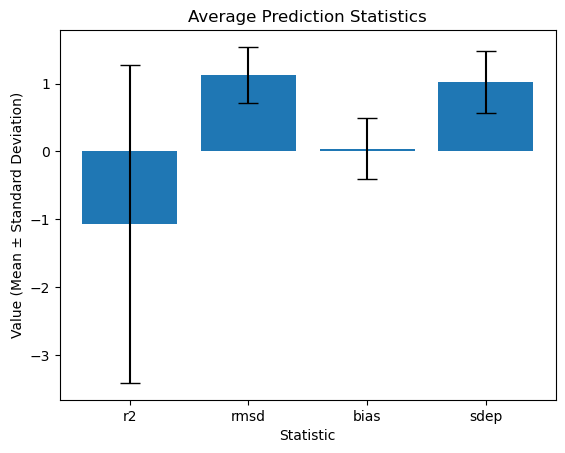

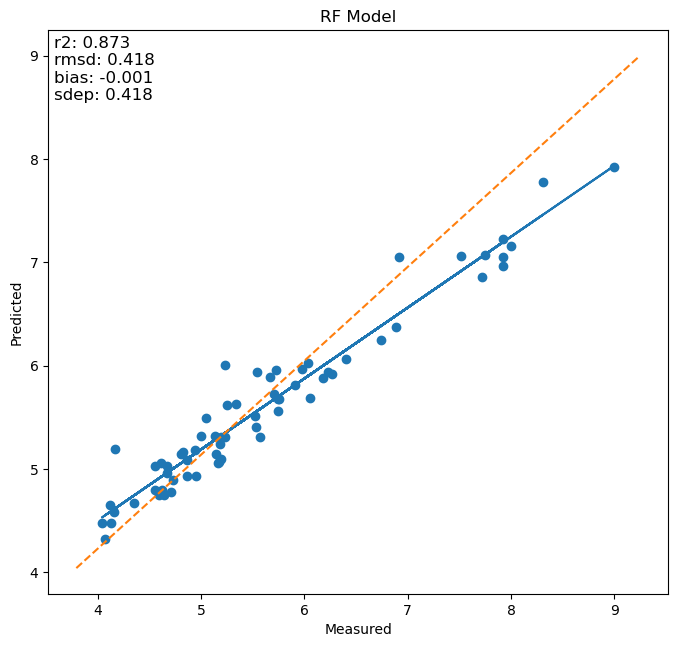

In [53]:
metaboliteModelStuff(testFile, testFile)

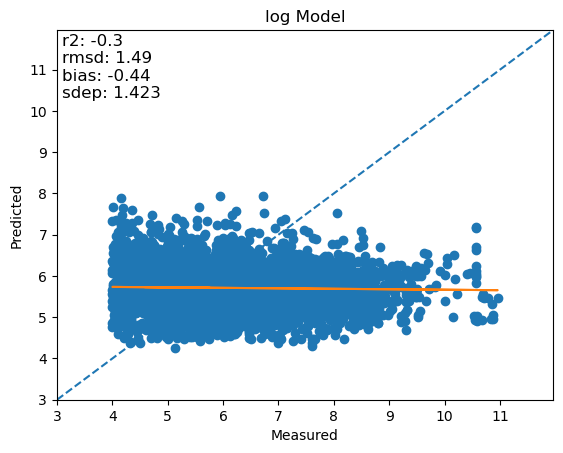

In [10]:
gradModelStuff(testFile, trainFile)

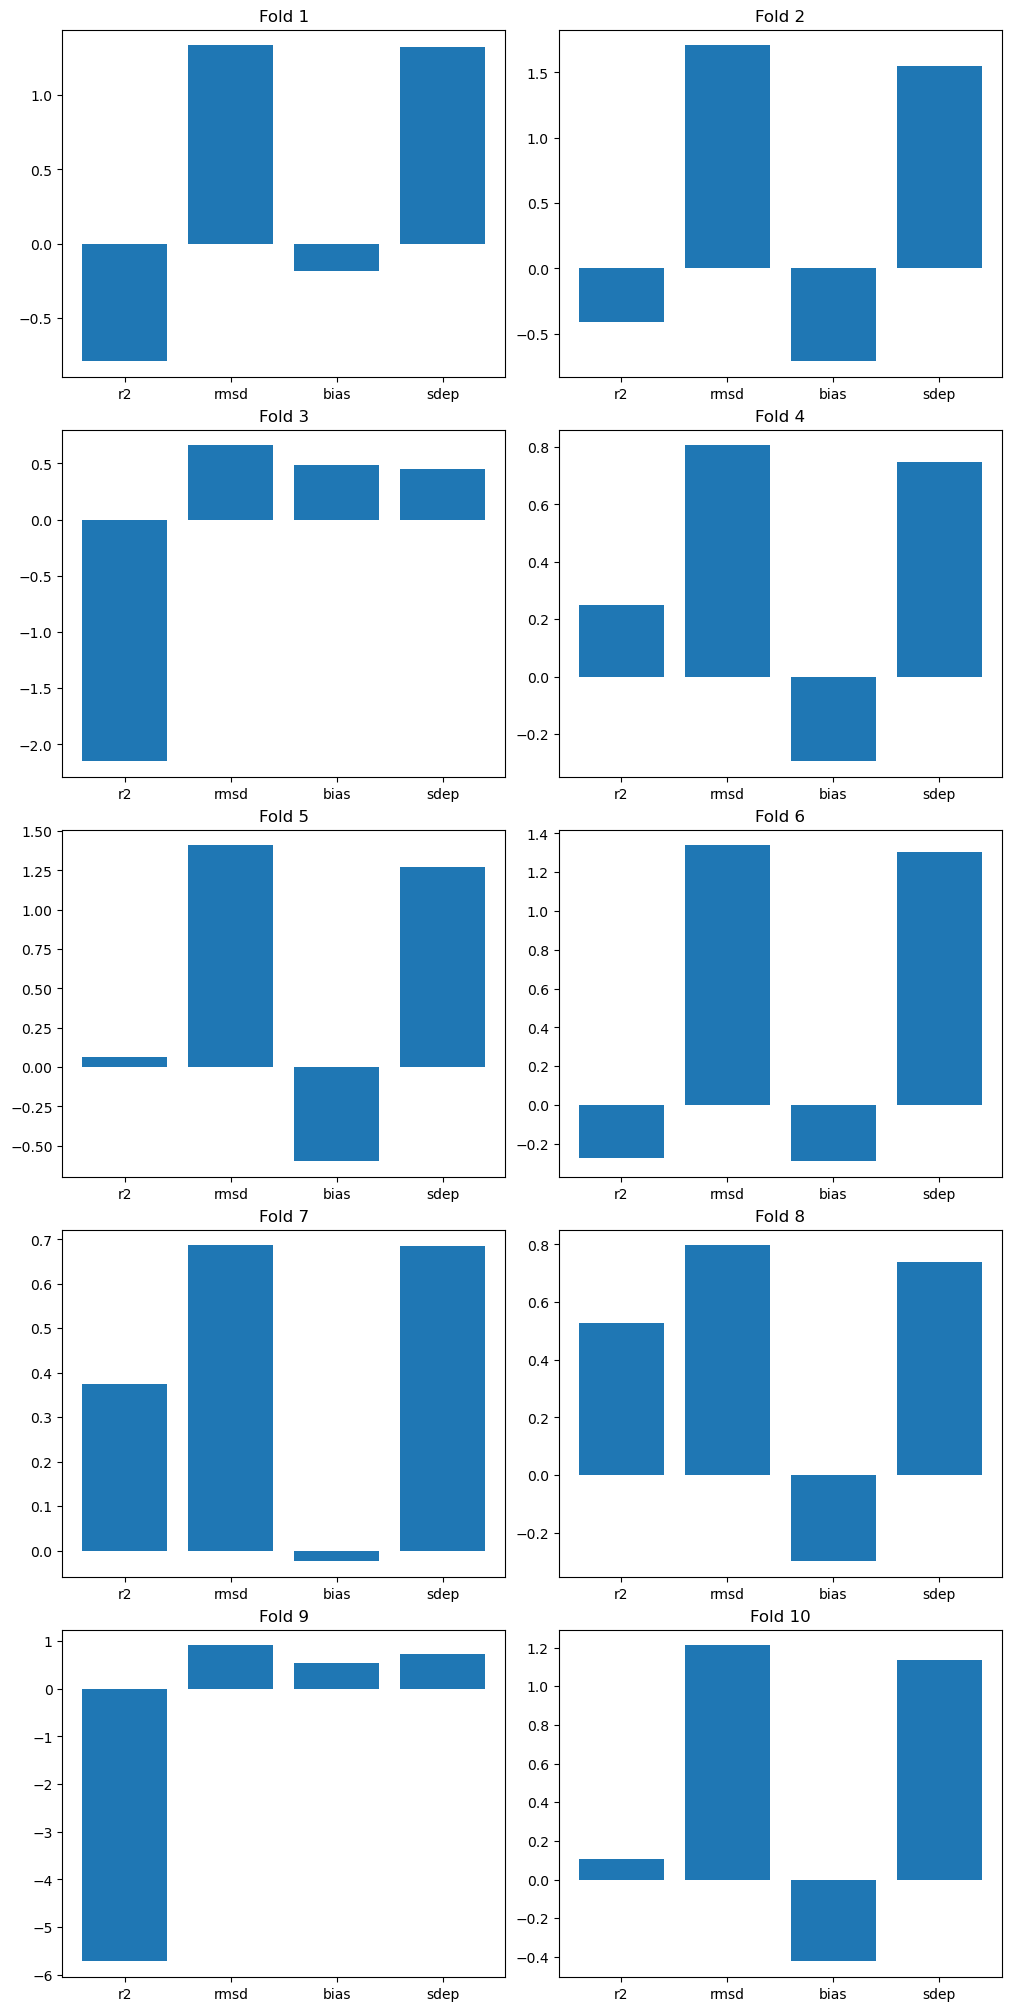

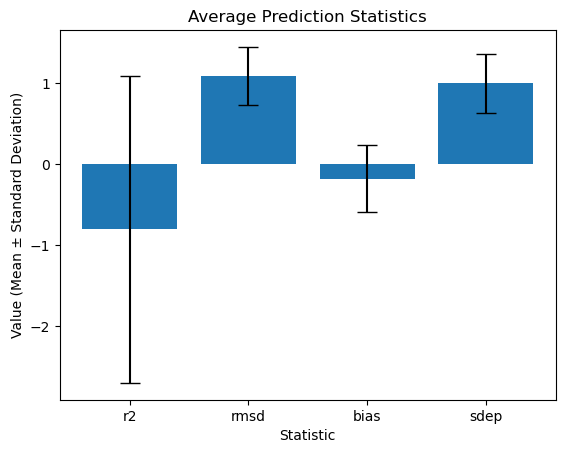

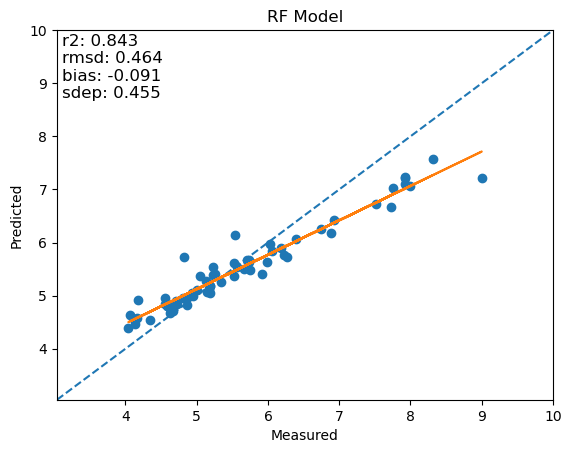

In [10]:
makeModel(testFile, testFile, "Morgan", "RF")